In [6]:
import json
import datetime
import time, os
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pymongo import MongoClient

from tqdm.notebook import tqdm

from wordcloud import WordCloud

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [8]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords 
from nltk import pos_tag
import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [9]:
from gensim import corpora, models, similarities, matutils

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [12]:
client = MongoClient()
db = client.tv
show_info = db['show_info']

In [13]:
client.list_database_names()
list(db.tv.find({'subreddit': 'westworld'} ,{'_id':0, 'name':1 , 'episode_number': 1, 'tomato':1})) # ,{'_id':0, 'name':1 , 'episode_number': 1}

[{'episode_number': 1, 'name': 'The Original', 'tomato': '100%'},
 {'episode_number': 2, 'name': 'Chestnut', 'tomato': '96%'},
 {'episode_number': 3, 'name': 'The Stray', 'tomato': '90%'},
 {'episode_number': 4, 'name': 'Dissonance Theory', 'tomato': '96%'},
 {'episode_number': 5, 'name': 'Contrapasso', 'tomato': '93%'},
 {'episode_number': 6, 'name': 'The Adversary', 'tomato': '89%'},
 {'episode_number': 7, 'name': "Trompe L'Oeil", 'tomato': '96%'},
 {'episode_number': 8, 'name': 'Trace Decay', 'tomato': '95%'},
 {'episode_number': 9, 'name': 'The Well-Tempered Clavier', 'tomato': '86%'},
 {'episode_number': 10, 'name': 'The Bicameral Mind', 'tomato': '94%'},
 {'episode_number': 1, 'name': 'Journey Into Night', 'tomato': '87%'},
 {'episode_number': 2, 'name': 'Reunion', 'tomato': '95%'},
 {'episode_number': 3, 'name': 'Virtù e Fortuna', 'tomato': '100%'},
 {'episode_number': 4, 'name': 'The Riddle of the Sphinx', 'tomato': '95%'},
 {'episode_number': 5, 'name': 'Akane No Mai', 'tomato

In [15]:
list(db.tv.find({'subreddit': 'gameofthrones'} ,{'_id':0, 'subreddit':1 , 'air_date': 1, 'tomato': 1}))[0:10] #

[{'air_date': '2011-04-17', 'subreddit': 'gameofthrones', 'tomato': '100%'},
 {'air_date': '2011-04-24', 'subreddit': 'gameofthrones', 'tomato': '100%'},
 {'air_date': '2011-05-01', 'subreddit': 'gameofthrones', 'tomato': '86%'},
 {'air_date': '2011-05-08', 'subreddit': 'gameofthrones', 'tomato': '100%'},
 {'air_date': '2011-05-15', 'subreddit': 'gameofthrones', 'tomato': '95%'},
 {'air_date': '2011-05-22', 'subreddit': 'gameofthrones', 'tomato': '100%'},
 {'air_date': '2011-05-29', 'subreddit': 'gameofthrones', 'tomato': '100%'},
 {'air_date': '2011-06-05', 'subreddit': 'gameofthrones', 'tomato': '100%'},
 {'air_date': '2011-06-12', 'subreddit': 'gameofthrones', 'tomato': '100%'},
 {'air_date': '2011-06-19', 'subreddit': 'gameofthrones', 'tomato': '100%'}]

In [16]:
db.tv.count_documents({})

234

In [17]:
db.posts.count_documents({})

22974

In [18]:
db.comments.count_documents({})

46800

In [19]:
list(db.comments.find({'subreddit': 'gameofthrones'},{"episode":1})) # ,{'_id' : 0, 'title':1, 'selftext' : 1}

[{'_id': ObjectId('5ec551189dbdf5cbda7b6aa2'),
  'episode': {'air_date': '2011-04-17',
   'episode_number': 1,
   'name': 'Winter Is Coming',
   'season_number': 1,
   'subreddit': 'gameofthrones',
   'tomato': '100%'}},
 {'_id': ObjectId('5ec551189dbdf5cbda7b6aa3'),
  'episode': {'air_date': '2011-04-17',
   'episode_number': 1,
   'name': 'Winter Is Coming',
   'season_number': 1,
   'subreddit': 'gameofthrones',
   'tomato': '100%'}},
 {'_id': ObjectId('5ec551189dbdf5cbda7b6aa4'),
  'episode': {'air_date': '2011-04-17',
   'episode_number': 1,
   'name': 'Winter Is Coming',
   'season_number': 1,
   'subreddit': 'gameofthrones',
   'tomato': '100%'}},
 {'_id': ObjectId('5ec551189dbdf5cbda7b6aa5'),
  'episode': {'air_date': '2011-04-17',
   'episode_number': 1,
   'name': 'Winter Is Coming',
   'season_number': 1,
   'subreddit': 'gameofthrones',
   'tomato': '100%'}},
 {'_id': ObjectId('5ec551189dbdf5cbda7b6aa6'),
  'episode': {'air_date': '2011-04-17',
   'episode_number': 1,
   'n

In [20]:
def cleaning(string):  
    string = re.sub('http\S*', ' ', string)
    string = string.replace('[deleted]', '')
    string = string.replace('[Nsfw]', '')
    string = string.replace('[removed]', '')
    string = re.sub('\[.*?\]\(\#s', ' ', string)
    string = re.sub('\/u\/\S*', ' ', string)
    string = string.replace('\n', ' ')
    string = re.sub('\S*\d\S*', ' ', string)
    string = string.lower().strip()
    string = re.sub('[^a-z\s]', ' ', string)
    string = re.sub('\s{2,}', ' ', string)
    return string

In [21]:
def dummy(doc):
    return doc

In [22]:
corpus = []
corpus_raw = []
corpus_title_raw = []
#'subreddit': 'westworld'  # gameofthrones
posts_json = list(db.posts.find({'subreddit': 'westworld'},{'_id' : 0, 'title':1, 'selftext' : 1, 'episode.name' : 1, 'episode.tomato' : 1,'episode.season_number' : 1,'episode.episode_number' : 1}))
for post in posts_json:
    corpus.append(cleaning( post['title'] + ' ' + post.get('selftext','') ))
    corpus_raw.append( post['title'] + ' ' + post.get('selftext','') )
    corpus_title_raw.append( post['title'])

In [23]:
doc_ep_info = pd.DataFrame( [posts['episode'] for posts in posts_json] )
doc_ep_info['name'].unique()

array(['The Original', 'Chestnut', 'The Stray', 'Dissonance Theory',
       'Contrapasso', 'The Adversary', "Trompe L'Oeil", 'Trace Decay',
       'The Well-Tempered Clavier', 'The Bicameral Mind',
       'Journey Into Night', 'Reunion', 'Virtù e Fortuna',
       'The Riddle of the Sphinx', 'Akane No Mai', 'Phase Space',
       'Les Écorchés', 'Kiksuya', 'Vanishing Point', 'The Passenger',
       'Parce Domine', 'The Winter Line', 'The Absence of Field',
       'The Mother of Exiles', 'Genre', 'Decoherence', 'Passed Pawn',
       'Crisis Theory'], dtype=object)

In [24]:
corpus_raw[2]

'Misdirection at the beginning of the episode. I haven\'t seen anyone mention the beginning of the episode yet with Teddy meeting Up with Dolores. I thought that the intentional misdirection made for an awesome opening.\n\nTeddy arrives in town on a train with the "newcomers" or guests. We are led to believe that he is one of them. Various hosts interact with him the way they would guests (the Sheriff, the bartender, the prostitute) and then he sees Dolores.\n\nThe two reunite, and she mentions that he "came back to her" and Teddy said "he promised he would" making it sound as though Teddy is a guest and is returning to Westworld for another visit.\n\nTeddy accompanies Dolores home, and kills the hosts that attacked her house like a guest would kill NPCs. It isn\'t until Ed Harris/the man in black confronts Teddy that we realize Teddy is just a host and we\'ve been cleverly misled.\n\nI think this is a sign that we\'re going to be in for much more misdirection in the future as well. I 

In [25]:
corpus

['westworld ratings hbo s biggest premiere in nearly years with million viewers',
 'tl dw season episode a fly in the ointment',
 'misdirection at the beginning of the episode i haven t seen anyone mention the beginning of the episode yet with teddy meeting up with dolores i thought that the intentional misdirection made for an awesome opening teddy arrives in town on a train with the newcomers or guests we are led to believe that he is one of them various hosts interact with him the way they would guests the sheriff the bartender the prostitute and then he sees dolores the two reunite and she mentions that he came back to her and teddy said he promised he would making it sound as though teddy is a guest and is returning to westworld for another visit teddy accompanies dolores home and kills the hosts that attacked her house like a guest would kill npcs it isn t until ed harris the man in black confronts teddy that we realize teddy is just a host and we ve been cleverly misled i think 

In [28]:
# stop_words = set(stopwords.words('english')) 
stop_words = set(CountVectorizer(stop_words='english').get_stop_words())
stop_words.add('s')
stop_words.add('t')
stop_words.add('season')
stop_words.add('episode')
stop_words.add('seasons')
stop_words.add('episodes')
def stop_and_stem(doc):
    return [WordNetLemmatizer().lemmatize(w) for w in doc if not w in stop_words] # PorterStemmer().stem

def tokenizer(doc):
    # TreebankWordTokenizer
    
    tokens = TreebankWordTokenizer().tokenize(doc)
    tokens = pos_tag(tokens)
    tokens = [ token[0] for token in tokens if ('NN' in token[1]) or ('JJ' in token[1]) or ('VB' in token[1])]
    return stop_and_stem( tokens )

analyzer = CountVectorizer(tokenizer=tokenizer,ngram_range=(1,1)).build_analyzer()
def stemmed_words(doc):
    # WordNetLemmatizer().lemmatize
    # PorterStemmer().stem
    return [WordNetLemmatizer().lemmatize(w) for w in analyzer(doc) if not w.split in stop_words]

In [30]:
# TfidfTransformer
# CountVectorizer
vectorizer = CountVectorizer(tokenizer=tokenizer,
                                   preprocessor=None,
                                   min_df = 3, #.004,
                                   max_df = 0.7,
                                   ngram_range=(1,3),
#                                  analyzer=stemmed_words
                                  )
tfidf = TfidfTransformer()
doc_word = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(corpus),columns=vectorizer.get_feature_names())
df_combined_doc = pd.concat([doc_ep_info.add_prefix('doc_ep_info_')['doc_ep_info_name'], doc_word], axis = 1).groupby("doc_ep_info_name").sum()
df_combined_doc = tfidf.fit_transform(df_combined_doc)
doc_word = tfidf.transform(doc_word)

# Topic Modeling

In [31]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """
    Displays the top n terms in each topic
    """
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [32]:
# TruncatedSVD
# NMF
lsa = TruncatedSVD(10)

lsa.fit(df_combined_doc)

doc_topic = lsa.transform(doc_word)
lsa.explained_variance_ratio_

array([0.01557415, 0.14869065, 0.07446139, 0.05275299, 0.0497544 ,
       0.04695354, 0.04326639, 0.03999175, 0.03803044, 0.03682027])

In [33]:
# pd.concat([doc_ep_info.add_prefix('doc_ep_info_')['doc_ep_info_name'], doc_word], axis = 1).groupby("doc_ep_info_name").sum()

In [34]:
topic_word = pd.DataFrame(lsa.components_.round(3),
#              index = ["component_1","component_2"],
             columns = vectorizer.get_feature_names())
topic_word.sort_values(by=[0], axis = 'columns', ascending = False)

,host,dolores,ford,william,westworld,think,know,bernard,maeve,park,...,friend need,friend need suffer,friend ve coming,friendship,specific host,special connection,fuck going,fuck guy,fucker,ford discussion
0,0.340,0.334,0.234,0.197,0.170,0.135,0.135,0.133,0.124,0.122,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
1,-0.142,0.202,-0.186,-0.111,-0.039,0.002,0.016,-0.049,0.118,-0.079,...,-0.002,-0.002,-0.002,-0.001,-0.002,-0.002,0.004,-0.001,-0.002,-0.002
2,-0.207,0.277,0.103,0.024,-0.043,-0.053,-0.003,-0.056,-0.015,-0.044,...,0.008,0.008,0.007,0.001,-0.004,0.002,-0.001,-0.001,0.003,-0.001
3,-0.116,0.115,-0.026,0.122,-0.043,-0.043,-0.051,-0.005,0.064,-0.094,...,0.002,0.002,0.002,0.000,-0.002,-0.003,0.002,0.006,0.001,0.003
4,-0.111,-0.135,0.048,-0.040,0.154,0.010,-0.031,-0.048,-0.239,0.012,...,-0.002,-0.002,-0.001,-0.003,-0.003,0.001,0.006,-0.002,-0.002,0.002
5,0.010,-0.092,0.049,0.106,-0.064,-0.012,-0.017,-0.169,0.083,-0.020,...,0.001,0.001,-0.000,0.002,0.001,-0.001,0.010,0.009,-0.000,0.008
6,-0.027,0.128,-0.087,-0.241,0.079,0.017,0.066,-0.097,0.101,0.015,...,-0.001,-0.001,-0.000,0.004,-0.005,0.001,-0.002,0.006,-0.001,0.003
7,0.051,0.002,0.022,-0.287,-0.037,-0.026,0.018,0.149,-0.008,0.056,...,0.004,0.004,0.003,-0.002,0.001,0.002,0.006,0.002,0.001,0.005
8,-0.087,0.134,-0.083,0.018,0.048,-0.024,-0.054,-0.185,0.008,0.000,...,0.004,0.004,0.004,0.006,0.000,-0.006,-0.001,0.007,0.005,-0.004
9,0.089,-0.070,-0.000,-0.228,0.011,0.023,0.006,0.094,0.087,0.033,...,0.005,0.005,0.003,0.007,0.005,0.001,0.002,0.002,0.003,-0.001


In [35]:
dict(zip(topic_word.columns, topic_word.T[0]))

{'aaron': 0.004,
 'aaron paul': 0.004,
 'abandon': 0.002,
 'abandoned': 0.004,
 'abernathy': 0.039,
 'abernathy body': 0.002,
 'abernathy carrying': 0.002,
 'abernathy did': 0.002,
 'abernathy dolores': 0.002,
 'abernathy find': 0.003,
 'abernathy head': 0.002,
 'abernathy ranch': 0.005,
 'aberrant': 0.002,
 'ability': 0.012,
 'able': 0.024,
 'able control': 0.002,
 'abrams': 0.002,
 'absence': 0.005,
 'absence field': 0.004,
 'absent': 0.002,
 'absolute': 0.004,
 'absurd': 0.003,
 'absurd westworld': 0.002,
 'absurd westworld fan': 0.002,
 'abuse': 0.003,
 'abused': 0.002,
 'accent': 0.004,
 'accept': 0.005,
 'accepted': 0.002,
 'accepting': 0.003,
 'access': 0.015,
 'access data': 0.002,
 'access memory': 0.003,
 'accessed': 0.001,
 'accessing': 0.003,
 'accident': 0.008,
 'accident killed': 0.002,
 'accident killed said': 0.002,
 'accident knew': 0.001,
 'accident knew careful': 0.001,
 'accidental': 0.002,
 'accompanied': 0.002,
 'accomplish': 0.001,
 'accomplished': 0.002,
 'accor

In [36]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  1
host, dolores, ford, william, westworld, think, know, bernard, maeve, park

Topic  2
rehoboam, serac, caleb, dolores, hale, pearl, solomon, maeve, simulation, world

Topic  3
dolores, arnold, mib, gt, church, year, white church, ford, maze, lawrence

Topic  4
akecheta, finale, ake, spoiler, forge, william, dolores, logan, deleted, scene finale

Topic  5
rehoboam, kingdom, westworld, solomon, israel, king, akecheta, guest, man, father

Topic  6
akecheta, ake, lakota, drive, serac, kiksuya, william, img, processing img, maeve

Topic  7
fly, guest, black, akane, dolores, maeve, akecheta, ake, man black, musashi

Topic  8
hale, charlotte, akecheta, bernard, ake, arnold, rehoboam, ghost nation, nation, lakota

Topic  9
akane, kingdom, shogun, dolores, shogun world, cradle, teddy, gt, king, delos

Topic  10
serac, jean mi, gt, jean, mi, akane, bernard, host, maeve, narrative


(-0.5, 1999.5, 3999.5, -0.5)

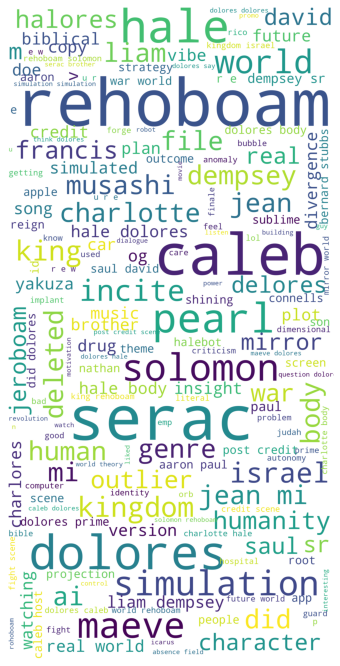

In [37]:
wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        width=200,
        height=400,
        max_font_size=40, 
        scale=10,
        random_state=1
    ).generate_from_frequencies(dict(zip(topic_word.columns, topic_word.T[1])))
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
#.generate(str(data))

(-1.0, 1.0)

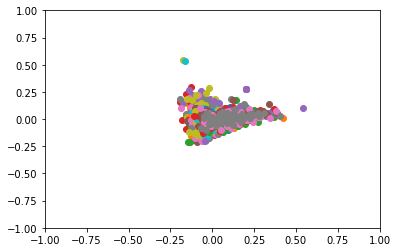

In [38]:
for ep_name in doc_ep_info['name'].unique():
    mask = doc_ep_info['name'] == ep_name
    plt.scatter(x = doc_topic[mask,1],y=doc_topic[mask,2])
plt.xlim((-1, 1))
plt.ylim((-1, 1))

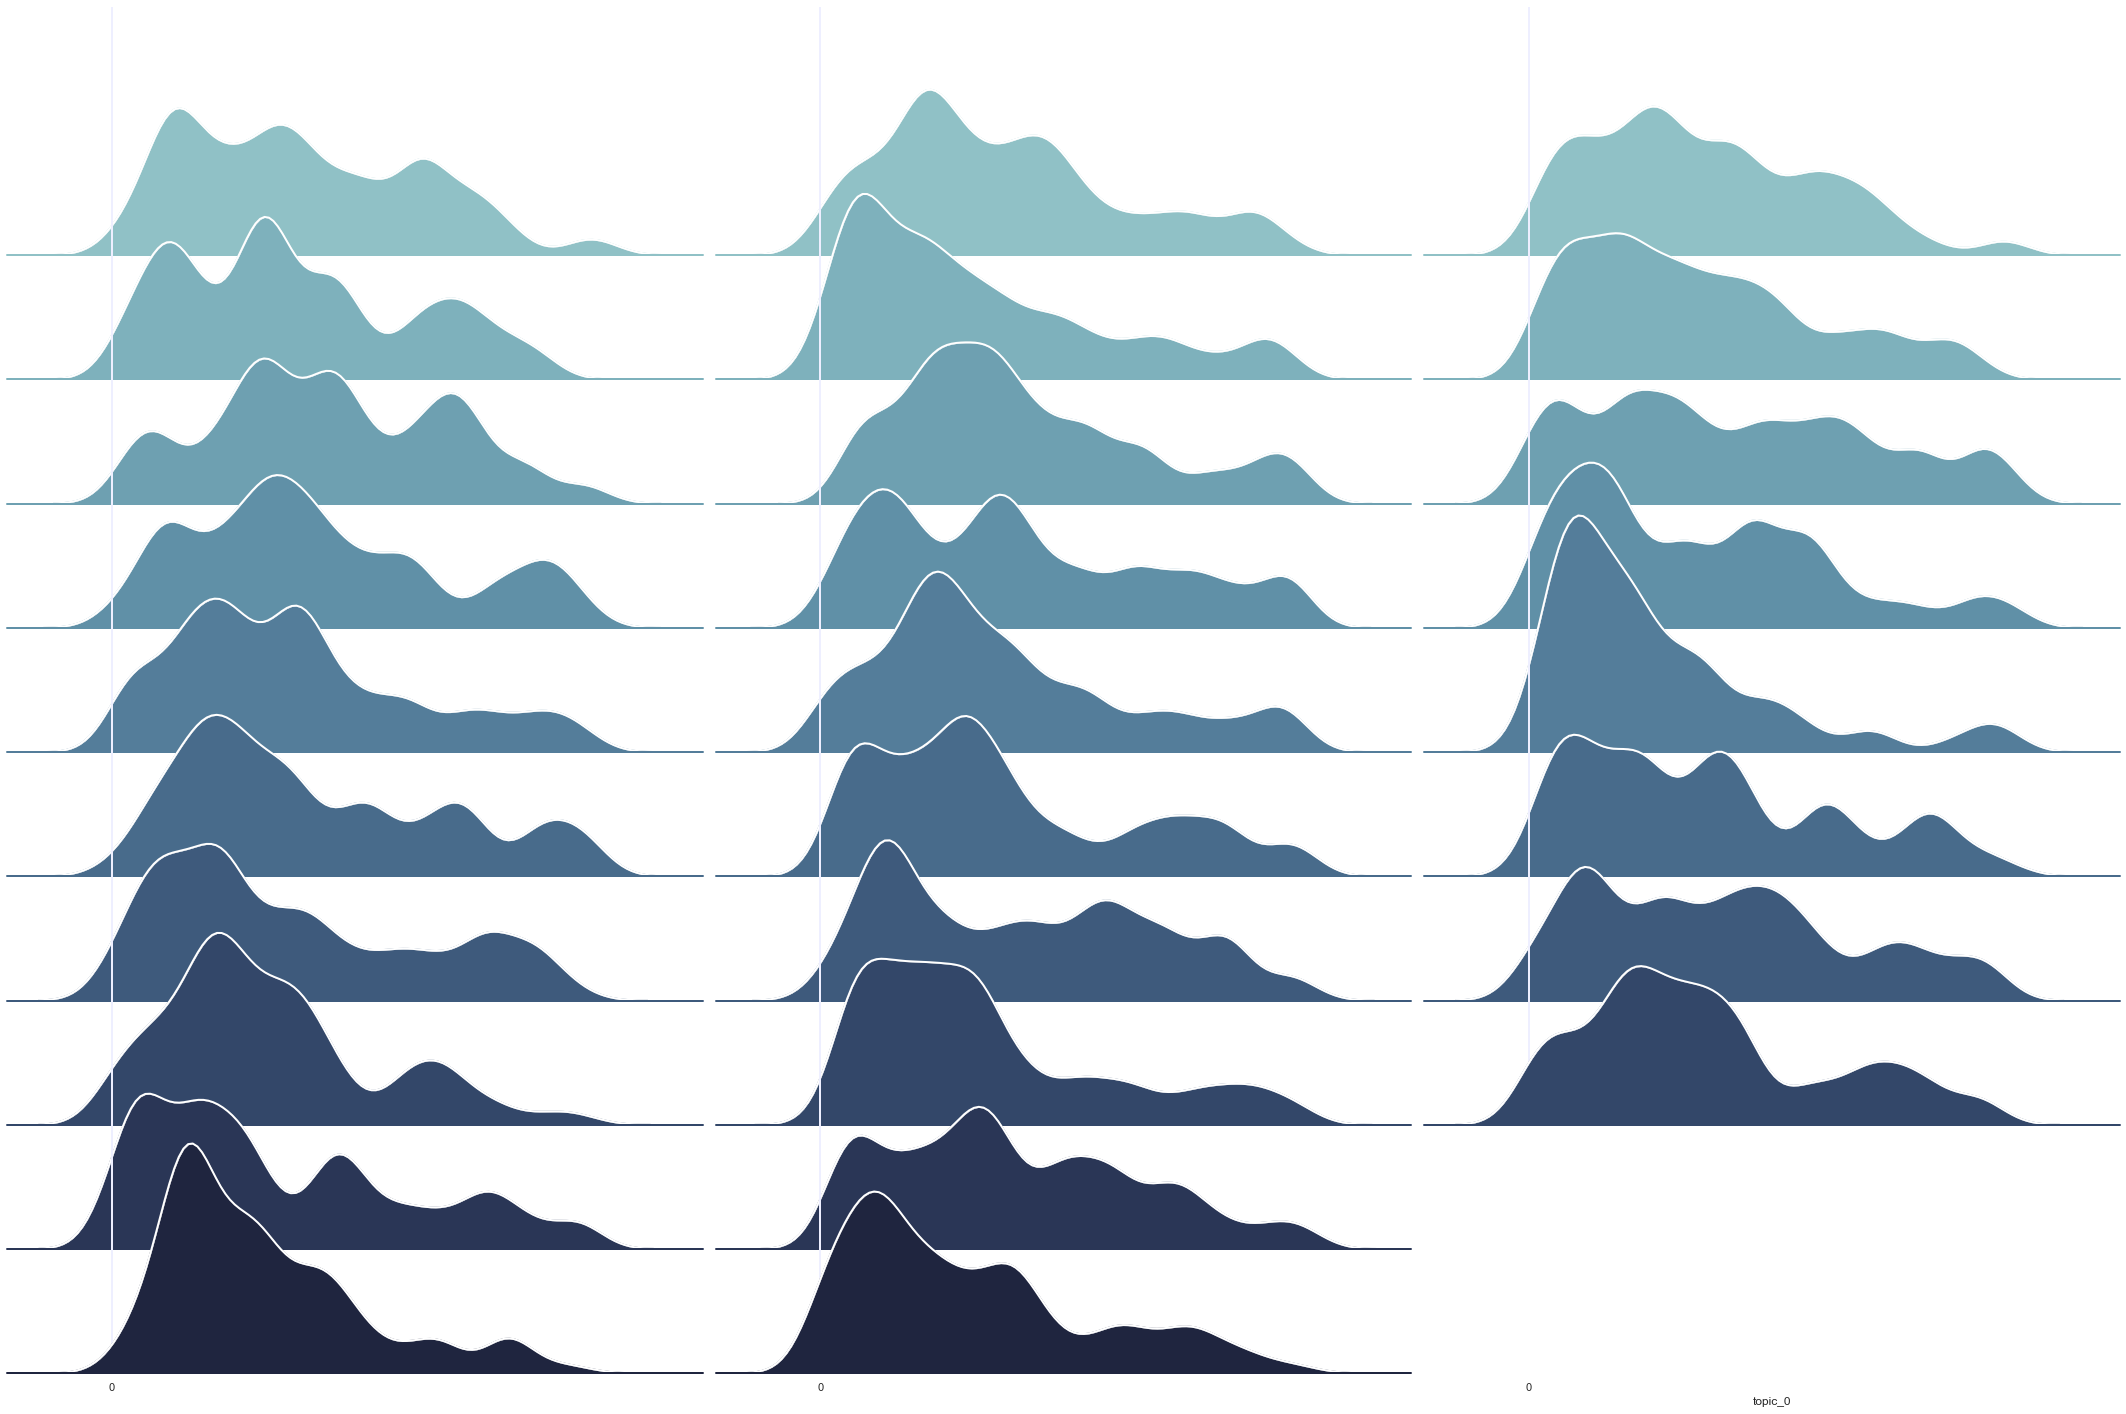

In [39]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(pd.concat([pd.DataFrame(doc_topic).add_prefix('topic_'), doc_ep_info], axis = 1),
                  row='episode_number', col = 'season_number', hue='episode_number', aspect=5, height=2, palette=pal) # 
g.map(sns.kdeplot, 'topic_0', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.01, clip = (-.2,.2))
g.map(sns.kdeplot, 'topic_0', clip_on=False, color="w", lw=2, bw=.01, clip = (-.2,.2))
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.grid, color='#eeefff', linestyle='-', linewidth=2)
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[])
g.set(xticks=[0])
g.despine(bottom=True, left=True)

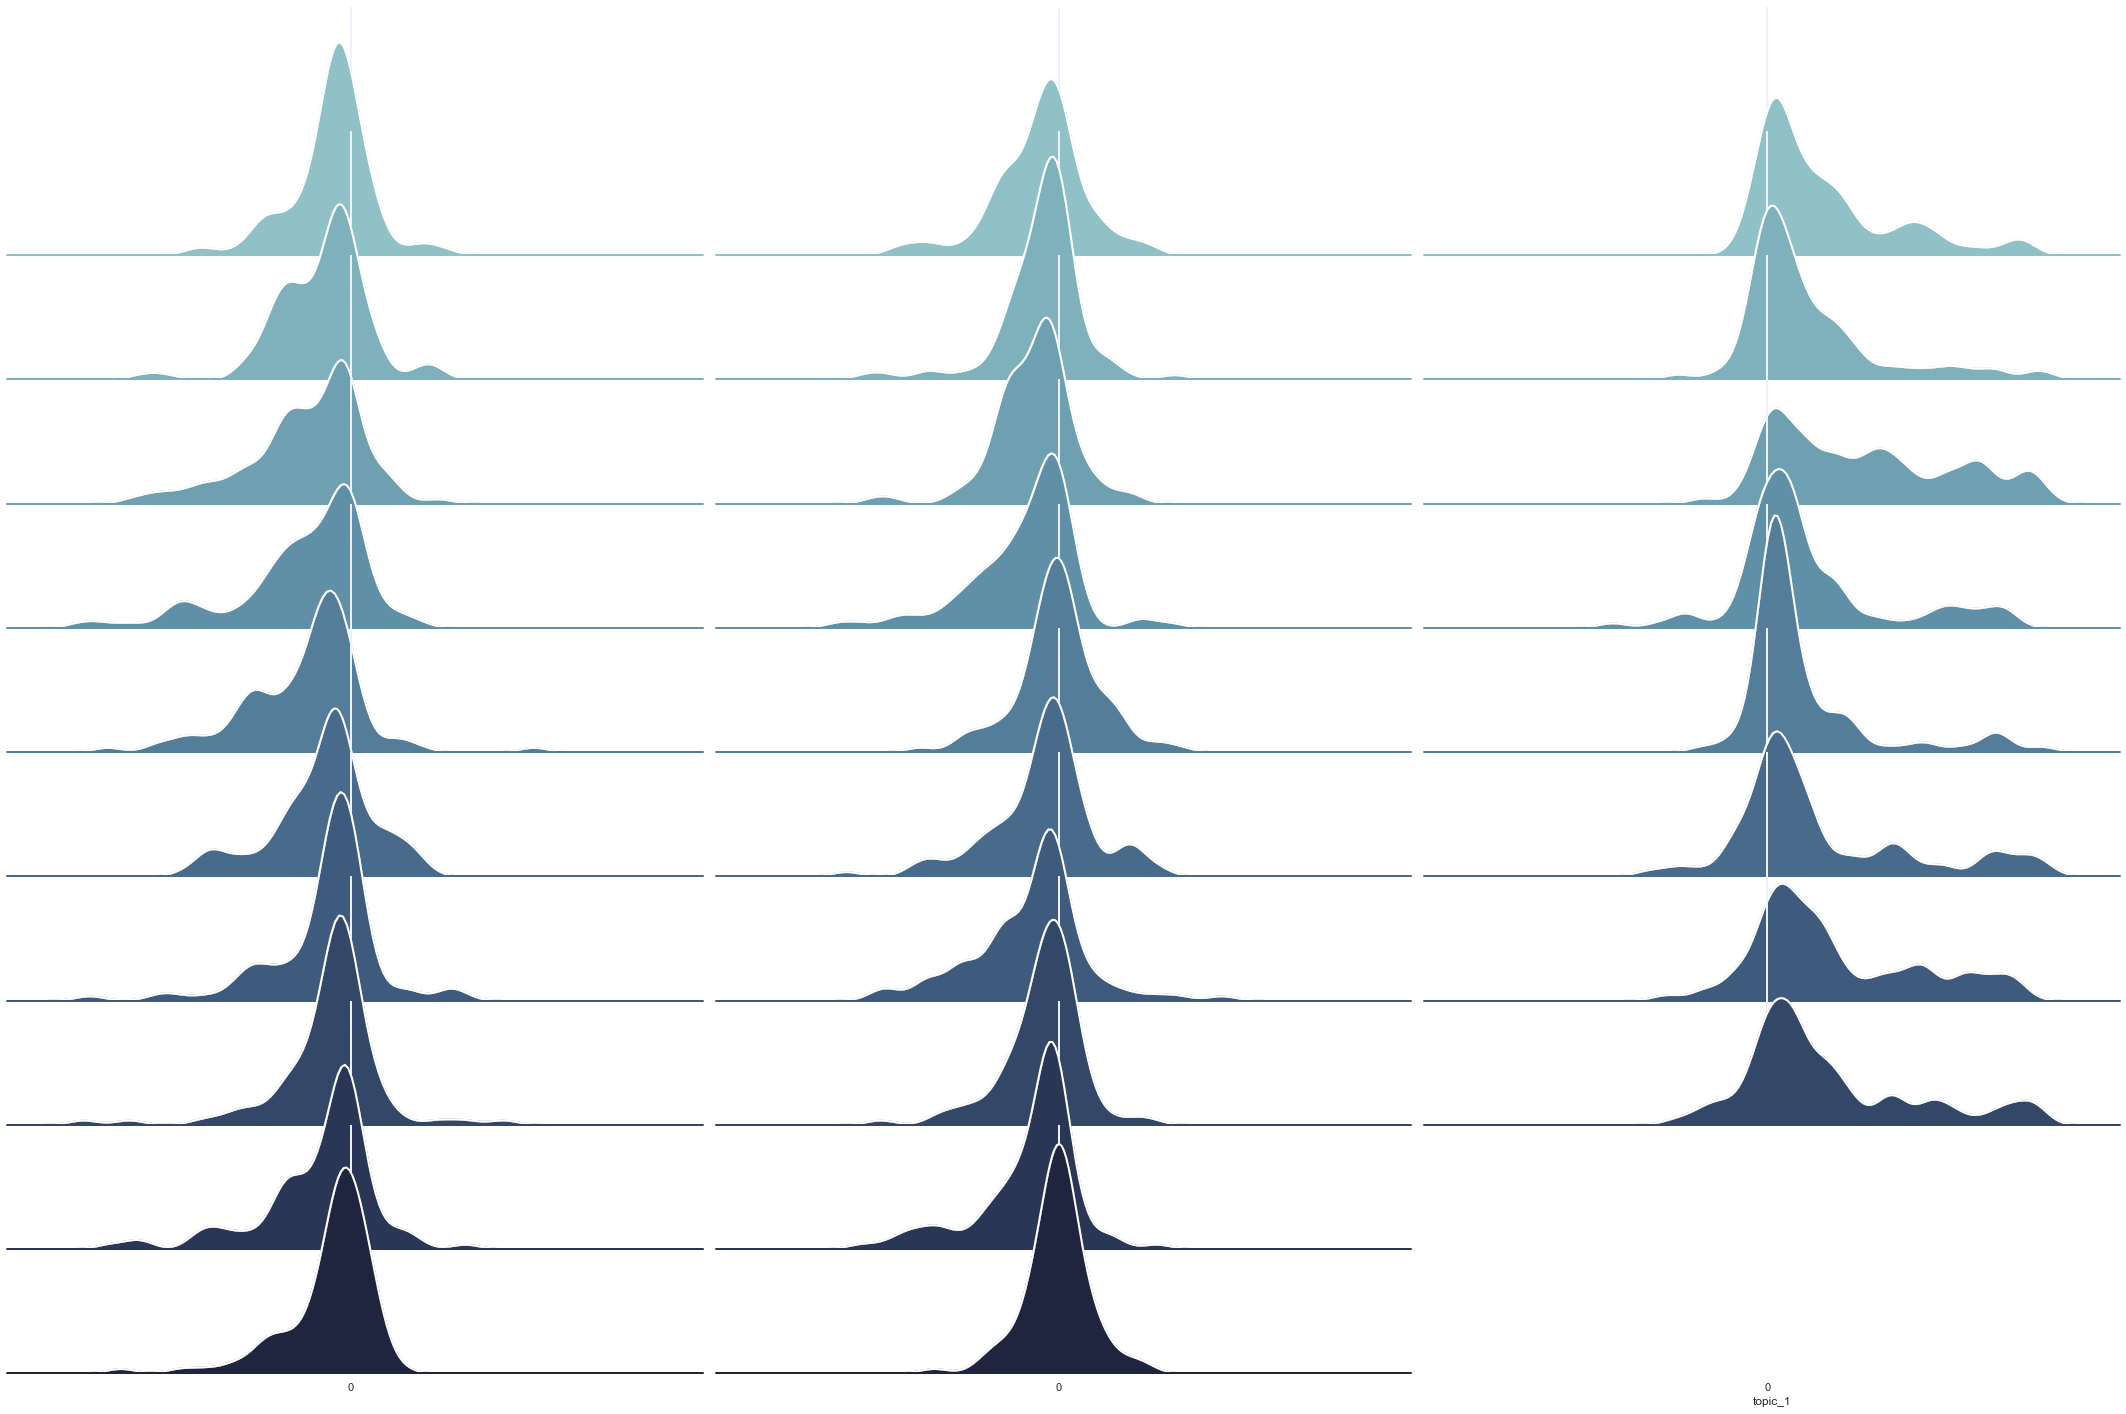

In [40]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(pd.concat([pd.DataFrame(doc_topic).add_prefix('topic_'), doc_ep_info], axis = 1),
                  row='episode_number', col = 'season_number', hue='episode_number', aspect=5, height=2, palette=pal) # 
g.map(sns.kdeplot, 'topic_1', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.01, clip = (-.2,.2))
g.map(sns.kdeplot, 'topic_1', clip_on=False, color="w", lw=2, bw=.01, clip = (-.2,.2))
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.grid, color='#eeefff', linestyle='-', linewidth=2)
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[])
g.set(xticks=[0])
g.despine(bottom=True, left=True)

In [41]:
nmf = NMF(3)
nmf.fit(df_combined_doc)
doc_topic = nmf.transform(doc_word)

topic_word = pd.DataFrame(nmf.components_.round(3),
#              index = ["component_1","component_2"],
             columns = vectorizer.get_feature_names())
topic_word.sort_values(by=[0], axis = 'columns', ascending = False)

,host,ford,william,westworld,dolores,delos,bernard,think,park,spoiler,...,fact dolores,serac brother,eye wide,serac doesn,serac rehoboam,serac say,serac think,serac want,sergeant,aaron
0,0.669,0.349,0.317,0.299,0.280,0.263,0.243,0.234,0.230,0.210,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.143,0.029,0.069,0.103,0.500,0.018,0.062,0.113,0.024,0.060,...,0.001,0.016,0.007,0.011,0.013,0.007,0.012,0.009,0.000,0.021
2,0.252,0.326,0.225,0.144,0.416,0.000,0.114,0.100,0.118,0.037,...,0.008,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.007,0.000


In [42]:
display_topics(nmf, vectorizer.get_feature_names(), 10)


Topic  1
host, ford, william, westworld, dolores, delos, bernard, think, park, spoiler

Topic  2
dolores, rehoboam, serac, caleb, hale, maeve, pearl, world, host, solomon

Topic  3
dolores, ford, arnold, host, mib, william, gt, year, maze, westworld


(0.0, 1.0)

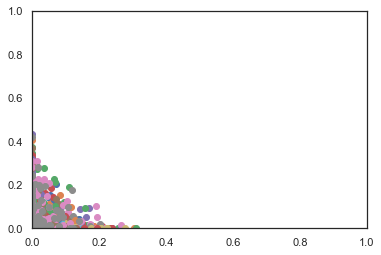

In [43]:
for ep_name in doc_ep_info['name'].unique():
    mask = doc_ep_info['name'] == ep_name
    plt.scatter(x = doc_topic[mask,0],y=doc_topic[mask,1])
plt.xlim((0, 1))
plt.ylim((0, 1))

In [44]:
df_combined_doc

<28x8845 sparse matrix of type '<class 'numpy.float64'>'
	with 55274 stored elements in Compressed Sparse Row format>

In [45]:
# lda_corpus = matutils.Dense2Corpus(df_combined_doc.values.T) 
lda_corpus = matutils.Sparse2Corpus(df_combined_doc.T)

In [46]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
len(id2word)

8845

In [47]:
lda = models.LdaModel(corpus=lda_corpus, num_topics=10, id2word=id2word, passes=5, iterations = 1000)
lda.print_topics()

[(0,
  '0.000*"host" + 0.000*"dolores" + 0.000*"ford" + 0.000*"dual" + 0.000*"westworld" + 0.000*"timeframe" + 0.000*"maeve" + 0.000*"arnold" + 0.000*"rehoboam" + 0.000*"know"'),
 (1,
  '0.004*"host" + 0.004*"dolores" + 0.003*"ford" + 0.002*"william" + 0.002*"westworld" + 0.002*"think" + 0.002*"know" + 0.002*"bernard" + 0.002*"park" + 0.002*"maeve"'),
 (2,
  '0.000*"dolores" + 0.000*"caleb" + 0.000*"host" + 0.000*"rehoboam" + 0.000*"pearl" + 0.000*"ford" + 0.000*"westworld" + 0.000*"hale" + 0.000*"kingdom" + 0.000*"bernard"'),
 (3,
  '0.000*"host" + 0.000*"ford" + 0.000*"william" + 0.000*"westworld" + 0.000*"dolores" + 0.000*"ghost nation" + 0.000*"think" + 0.000*"nation" + 0.000*"delos" + 0.000*"angela"'),
 (4,
  '0.000*"host" + 0.000*"bernard" + 0.000*"brain" + 0.000*"ford" + 0.000*"charlotte" + 0.000*"william" + 0.000*"spoiler" + 0.000*"memory" + 0.000*"dolores" + 0.000*"human"'),
 (5,
  '0.000*"finale" + 0.000*"forge" + 0.000*"scene finale" + 0.000*"virgin" + 0.000*"destroy" + 0.00

In [48]:
print(lda_corpus)

# Clustering

In [49]:
#kmean
#dbscan
doc_topic.shape

(2800, 3)

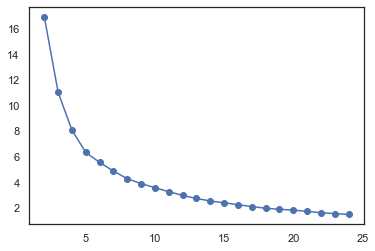

In [50]:
interia = [None,None]
for k in tqdm(range(2,25,1)):
    km = KMeans(n_clusters=k,random_state=42)
    km.fit(doc_topic)
    interia.append(km.inertia_)
plt.plot(interia, marker = 'o')

(array([2357.,  217.,  226.]),
 array([0, 1, 2, 3]),
 <a list of 3 Patch objects>)

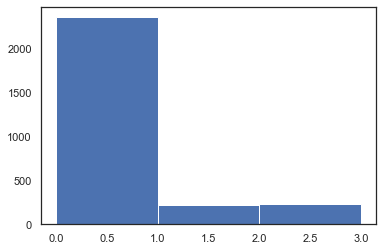

In [51]:
# doc_word
# doc_topic
k = 3
km = KMeans(n_clusters=k,random_state=42)
doc_topic_cluster = km.fit_predict(doc_topic)
plt.hist(doc_topic_cluster,bins=range(k+1))

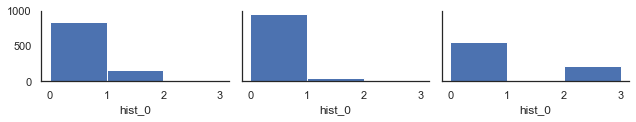

In [52]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(pd.concat([pd.DataFrame(doc_topic_cluster).add_prefix('hist_'), doc_ep_info], axis = 1),
                  col = 'season_number', aspect=1.5, height=2, palette=pal) # row='episode_number', hue='episode_number'
g.map(plt.hist, 'hist_0', bins = range(k+1))
# g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
# g.set(yticks=[])
# g.despine(bottom=True, left=True)

(array([ 6., 30.,  5.,  5.,  6., 15.]),
 array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 <a list of 6 Patch objects>)

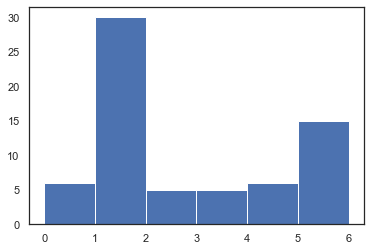

In [53]:
dbscan = DBSCAN(eps = .6, min_samples = 5)
doc_topic_cluster = dbscan.fit_predict(doc_word)
doc_topic_cluster=doc_topic_cluster[doc_topic_cluster!=-1]
plt.hist(doc_topic_cluster,bins=np.unique(doc_topic_cluster))

# Sentiment Analysis

In [54]:
sid = SentimentIntensityAnalyzer()

In [55]:
sentiment = pd.DataFrame([ sid.polarity_scores(raw) for raw in corpus_raw ])
sentiment_title = pd.DataFrame([ sid.polarity_scores(raw) for raw in corpus_title_raw ])

In [56]:
sentiment
sentiment = pd.concat([pd.DataFrame(sentiment), doc_ep_info], axis = 1)
sentiment_title = pd.concat([pd.DataFrame(sentiment_title), doc_ep_info], axis = 1)

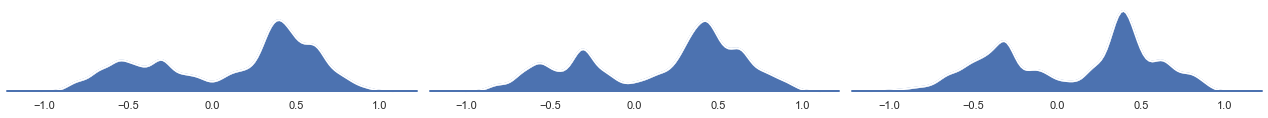

In [57]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(sentiment_title[sentiment_title.compound != 0], #[sentiment.compound != 0]
                   col = 'season_number', aspect=3, height=2, palette=pal) # row='episode_number',
g.map(sns.kdeplot, 'compound', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.05, clip = (-1,1))
g.map(sns.kdeplot, 'compound', clip_on=False, color="w", lw=2, bw=.05, clip = (-1,1))
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [58]:
sentiment['tomato'] = pd.to_numeric(doc_ep_info['tomato'].str.replace('%',''))
sentiment['dummy_neg'] = sentiment['compound'] <= -0.05
sentiment['dummy_pos'] = sentiment['compound'] >= 0.05
sentiment['dummy_neu'] = (1 - (sentiment['dummy_pos'].astype(int) + sentiment['dummy_neg'].astype(int)))
sentiment['dummy_comp'] = sentiment['dummy_pos'].astype(int) - sentiment['dummy_neg'].astype(int)
sentiment_episode = sentiment.groupby("name").mean() # 'mean','var')
sentiment_episode['masked_comp'] = sentiment[sentiment.compound != 0][['name','compound']].groupby("name").mean()
sentiment_episode = pd.concat([sentiment_episode, sentiment[['name','neg','pos','compound']].groupby("name").var().add_prefix('var_')], axis = 1)
sentiment_episode.head(5)

,neg,neu,pos,compound,episode_number,season_number,tomato,dummy_neg,dummy_pos,dummy_neu,dummy_comp,masked_comp,var_neg,var_pos,var_compound
name,,,,,,,,,,,,,,,
Akane No Mai,0.04148,0.87281,0.08572,0.168990,5,2,90,0.16,0.39,0.45,0.23,0.291362,0.005382,0.015654,0.295637
Chestnut,0.06315,0.83946,0.09739,0.062048,2,1,96,0.32,0.45,0.23,0.13,0.080582,0.010602,0.014477,0.344342
Contrapasso,0.05108,0.87425,0.07464,0.092240,5,1,93,0.29,0.41,0.30,0.12,0.129915,0.005358,0.007519,0.370007
Crisis Theory,0.09294,0.81268,0.09435,0.150059,8,3,50,0.28,0.47,0.25,0.19,0.200079,0.022540,0.009003,0.303653
Decoherence,0.05869,0.85570,0.08566,0.059188,6,3,84,0.25,0.35,0.40,0.10,0.095465,0.009661,0.026165,0.240922


In [59]:
sentiment_title['tomato'] = pd.to_numeric(doc_ep_info['tomato'].str.replace('%',''))
sentiment_title['dummy_neg'] = sentiment_title['compound'] <= -0.05
sentiment_title['dummy_pos'] = sentiment_title['compound'] >= 0.05
sentiment_title['dummy_neu'] = (1 - (sentiment_title['dummy_pos'].astype(int) + sentiment_title['dummy_neg'].astype(int)))
sentiment_title['dummy_comp'] = sentiment_title['dummy_pos'].astype(int) - sentiment_title['dummy_neg'].astype(int)
sentiment_title_episode = sentiment_title.groupby("name").mean() # 'mean','var')
sentiment_title_episode['masked_comp'] = sentiment_title[sentiment_title.compound != 0][['name','compound']].groupby("name").mean()
sentiment_title_episode = pd.concat([sentiment_title_episode, sentiment_title[['name','neg','pos','compound']].groupby("name").var().add_prefix('var_')], axis = 1)
sentiment_title_episode.head(5)

,neg,neu,pos,compound,episode_number,season_number,tomato,dummy_neg,dummy_pos,dummy_neu,dummy_comp,masked_comp,var_neg,var_pos,var_compound
name,,,,,,,,,,,,,,,
Akane No Mai,0.03777,0.88293,0.07932,0.064199,5,2,90,0.09,0.25,0.66,0.16,0.173511,0.008129,0.021684,0.059459
Chestnut,0.04210,0.86403,0.09388,0.077167,2,1,96,0.12,0.30,0.58,0.18,0.183731,0.014025,0.026278,0.083943
Contrapasso,0.04330,0.89025,0.06645,0.045161,5,1,93,0.14,0.25,0.61,0.11,0.110149,0.013371,0.013086,0.081457
Crisis Theory,0.09188,0.81735,0.09074,0.061206,8,3,50,0.19,0.27,0.54,0.08,0.133057,0.040853,0.022724,0.108882
Decoherence,0.04581,0.88081,0.07337,0.030877,6,3,84,0.15,0.22,0.63,0.07,0.079172,0.012712,0.028893,0.065977


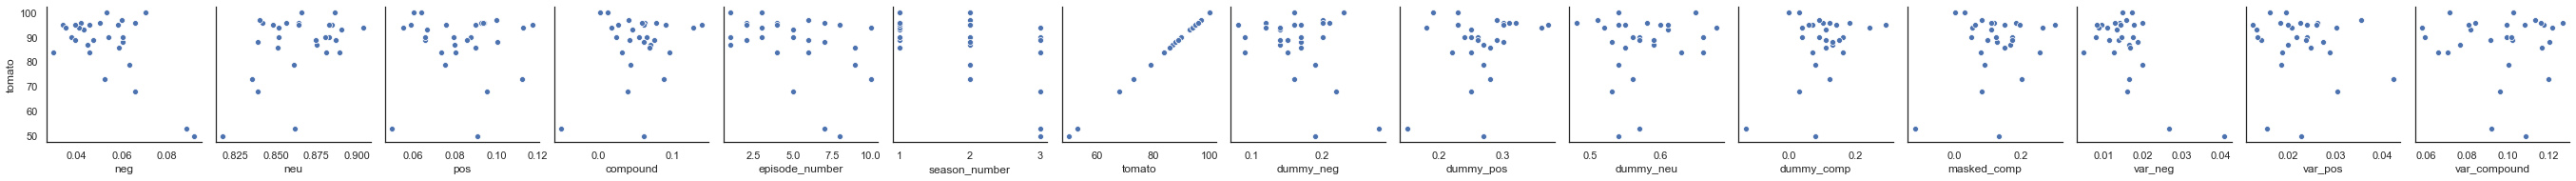

In [60]:
sns.pairplot(sentiment_title_episode,y_vars='tomato',x_vars=sentiment_title_episode.columns)

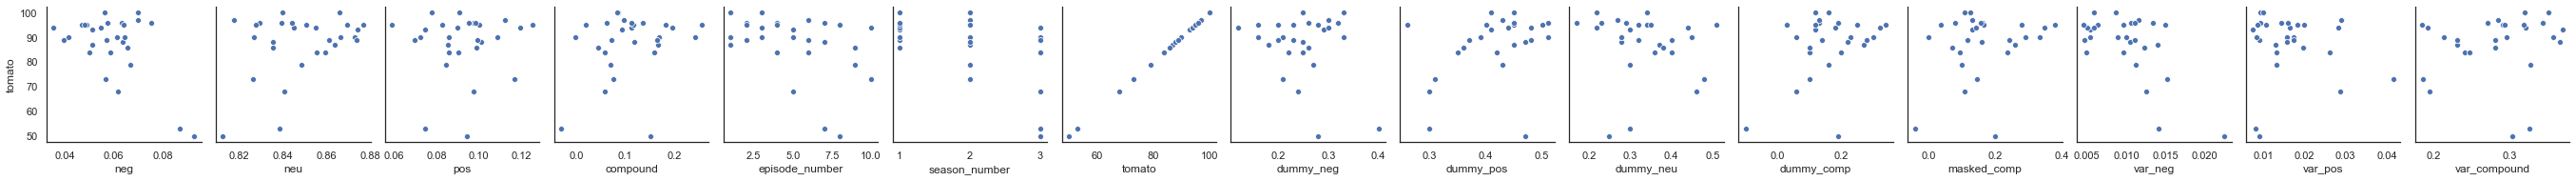

In [61]:
sns.pairplot(sentiment_episode,y_vars='tomato',x_vars=sentiment_episode.columns)

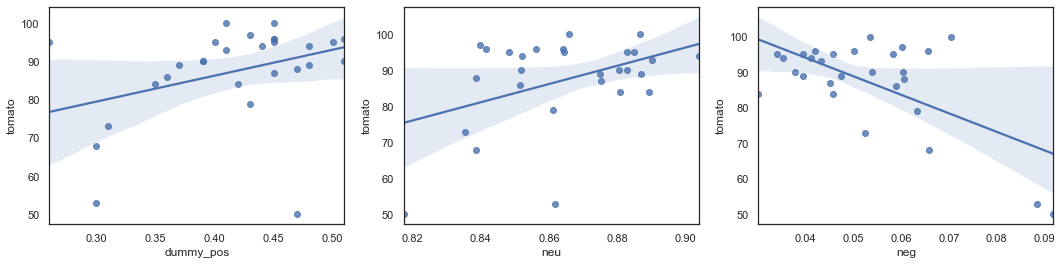

In [62]:
fig = plt.figure(figsize = (18,4))
plt.subplot(1,3,1)
sns.regplot(x="dummy_pos", y="tomato", data=sentiment_episode)
plt.subplot(1,3,2)
sns.regplot(x="neu", y="tomato", data=sentiment_title_episode)
plt.subplot(1,3,3)
sns.regplot(x="neg", y="tomato", data=sentiment_title_episode)

In [63]:
corpus_comments_raw = []
#'subreddit': 'westworld'  # gameofthrones
comments_json = list(db.comments.find({'subreddit': 'gameofthrones'},{'_id' : 0, 'body':1, 'episode.name' : 1, 'episode.tomato' : 1,'episode.season_number' : 1,'episode.episode_number' : 1}))
for comment in comments_json:
    corpus_comments_raw.append( comment['body'])
doc_ep_info_comments = pd.DataFrame( [comments['episode'] for comments in comments_json] )
doc_ep_info_comments['name'].unique()

array(['Winter Is Coming', 'The Kingsroad', 'Lord Snow',
       'Cripples, Bastards, and Broken Things', 'The Wolf and the Lion',
       'A Golden Crown', 'You Win or You Die', 'The Pointy End', 'Baelor',
       'Fire and Blood', 'The North Remembers', 'The Night Lands',
       'What is Dead May Never Die', 'Garden of Bones',
       'The Ghost of Harrenhal', 'The Old Gods and the New',
       'A Man Without Honor', 'The Prince of Winterfell', 'Blackwater',
       'Valar Morghulis', 'Valar Dohaeris', 'Dark Wings, Dark Words',
       'Walk of Punishment', 'And Now His Watch Is Ended',
       'Kissed by Fire', 'The Climb', 'The Bear and the Maiden Fair',
       'Second Sons', 'The Rains of Castamere', 'Mhysa', 'Two Swords',
       'The Lion and the Rose', 'Breaker of Chains', 'Oathkeeper',
       'First of His Name', 'The Laws of Gods and Men', 'Mockingbird',
       'The Mountain and the Viper', 'The Watchers on the Wall',
       'The Children', 'The Wars to Come', 'The House of Black and

In [64]:
sentiment_comments = pd.DataFrame([ sid.polarity_scores(raw) for raw in corpus_comments_raw ])
sentiment_comments = pd.concat([pd.DataFrame(sentiment_comments), doc_ep_info_comments], axis = 1)

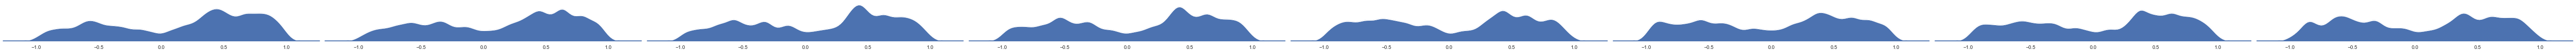

In [65]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(sentiment_comments[sentiment_comments.compound != 0], #[sentiment.compound != 0]
                   col = 'season_number', aspect=5, height=2, palette=pal) # row='episode_number',
g.map(sns.kdeplot, 'compound', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.05, clip = (-1,1))
g.map(sns.kdeplot, 'compound', clip_on=False, color="w", lw=2, bw=.05, clip = (-1,1))
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [66]:
sentiment_comments['tomato'] = pd.to_numeric(doc_ep_info_comments['tomato'].str.replace('%',''))
sentiment_comments['dummy_neg'] = sentiment_comments['compound'] <= -0.05
sentiment_comments['dummy_pos'] = sentiment_comments['compound'] >= 0.05
sentiment_comments['dummy_neu'] = (1 - (sentiment_comments['dummy_pos'].astype(int) + sentiment_comments['dummy_neg'].astype(int)))
sentiment_comments['dummy_comp'] = sentiment_comments['dummy_pos'].astype(int) - sentiment_comments['dummy_neg'].astype(int)
sentiment_comments_episode = sentiment_comments.groupby("name").mean() # 'mean','var')
sentiment_comments_episode['masked_comp'] = sentiment_comments[sentiment_comments.compound != 0][['name','compound']].groupby("name").mean()
sentiment_comments_episode = pd.concat([sentiment_comments_episode, sentiment_comments[['name','neg','pos','compound']].groupby("name").var().add_prefix('var_')], axis = 1)
sentiment_comments_episode.head(10)

,neg,neu,pos,compound,episode_number,season_number,tomato,dummy_neg,dummy_pos,dummy_neu,dummy_comp,masked_comp,var_neg,var_pos,var_compound
name,,,,,,,,,,,,,,,
A Golden Crown,0.063775,0.809190,0.127035,0.155000,6,1,100,0.215,0.490,0.295,0.275,0.216784,0.009206,0.022207,0.236836
A Knight of the Seven Kingdoms,0.102865,0.775855,0.121285,0.052678,2,8,87,0.330,0.460,0.210,0.130,0.065848,0.020508,0.018246,0.255739
A Man Without Honor,0.089480,0.796080,0.114440,0.050308,7,2,96,0.265,0.375,0.360,0.110,0.077997,0.023060,0.027360,0.192507
And Now His Watch Is Ended,0.077630,0.799395,0.122980,0.139146,4,3,100,0.230,0.440,0.330,0.210,0.198779,0.014516,0.022081,0.201446
Baelor,0.093410,0.790255,0.116305,0.074510,9,1,100,0.295,0.405,0.300,0.110,0.104209,0.022463,0.019546,0.236933
Battle of the Bastards,0.122005,0.756860,0.121150,0.026329,9,6,98,0.320,0.455,0.225,0.135,0.033540,0.023262,0.017449,0.276280
Beyond the Wall,0.094735,0.795170,0.110110,0.054378,6,7,84,0.355,0.420,0.225,0.065,0.068833,0.013720,0.013318,0.265819
Blackwater,0.111910,0.755810,0.132270,0.037016,9,2,100,0.315,0.350,0.335,0.035,0.053261,0.029524,0.036927,0.209185
Blood of My Blood,0.101010,0.770470,0.128500,0.031665,6,6,88,0.355,0.475,0.170,0.120,0.037922,0.016123,0.020045,0.278323


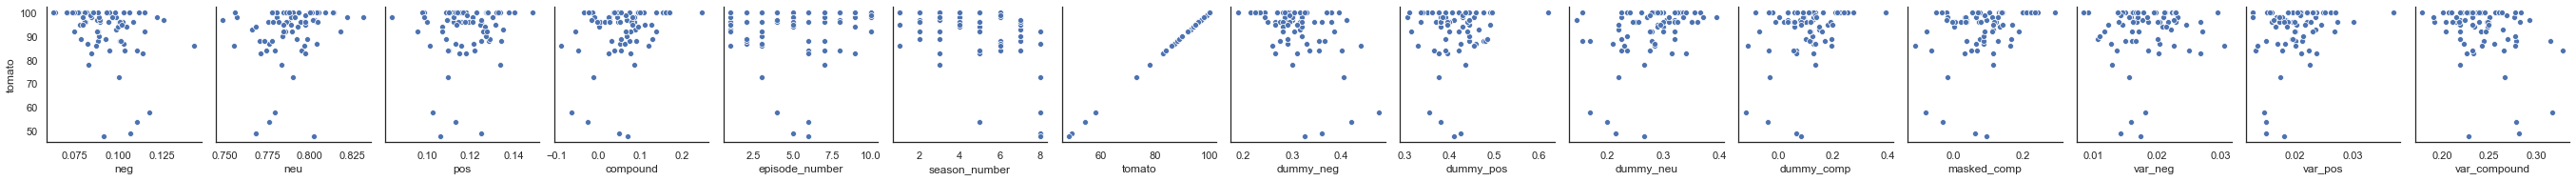

In [67]:
sns.pairplot(sentiment_comments_episode,y_vars='tomato',x_vars=sentiment_comments_episode.columns)

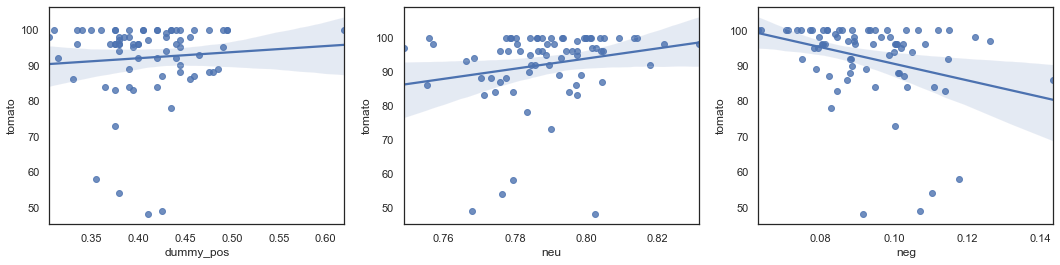

In [68]:
fig = plt.figure(figsize = (18,4))
plt.subplot(1,3,1)
sns.regplot(x="dummy_pos", y="tomato", data=sentiment_comments_episode)
plt.subplot(1,3,2)
sns.regplot(x="neu", y="tomato", data=sentiment_comments_episode)
plt.subplot(1,3,3)
sns.regplot(x="neg", y="tomato", data=sentiment_comments_episode)

# Other

In [69]:
corpus = []

#'subreddit': 'westworld'  # gameofthrones
posts_json = list(db.posts.find({},{'_id' : 0, 'title':1, 'selftext' : 1, 'subreddit': 1, 'episode.name' : 1, 'episode.tomato' : 1,'episode.season_number' : 1,'episode.episode_number' : 1}))
for post in posts_json:
    if 'tomato' in post['episode'].keys():
        corpus.append(cleaning( post['title'] + ' ' + post.get('selftext','') ))
doc_ep_info = pd.DataFrame( [posts['episode'] for posts in posts_json] )
doc_ep_info['subreddit'] = [posts['subreddit'] for posts in posts_json]
doc_ep_info = doc_ep_info.dropna()

In [70]:
doc_ep_info['tomato'] = pd.to_numeric(doc_ep_info['tomato'].str.replace('%',''))
doc_ep_info['mean_tomato'] =doc_ep_info.groupby("subreddit")['tomato'].transform('mean')
doc_ep_info['mean_tomato'] = doc_ep_info['tomato'] > doc_ep_info['mean_tomato']

In [71]:
# TfidfTransformer
# CountVectorizer
def tokenizer(doc):
    # TreebankWordTokenizer
    
    tokens = TreebankWordTokenizer().tokenize(doc)
#     tokens = pos_tag(tokens)
#     tokens = [ token[0] for token in tokens if ('NN' in token[1]) or ('JJ' in token[1]) or ('VB' in token[1])]
    return stop_and_stem( tokens )

vectorizer = CountVectorizer(tokenizer=tokenizer,
                                   preprocessor=None,
                                   min_df = .004,
                                   max_df = 0.7,
                                   ngram_range=(1,1),
#                                  analyzer=stemmed_words
                                  )
doc_word = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(corpus),columns=vectorizer.get_feature_names())
df_combined_doc = pd.concat([doc_ep_info.add_prefix('doc_ep_info_')['doc_ep_info_subreddit'], doc_word], axis = 1).groupby("doc_ep_info_subreddit").sum()
# df_combined_doc = pd.concat([doc_ep_info.add_prefix('doc_ep_info_')['doc_ep_info_mean_tomato'], doc_word], axis = 1).groupby("doc_ep_info_mean_tomato").sum()

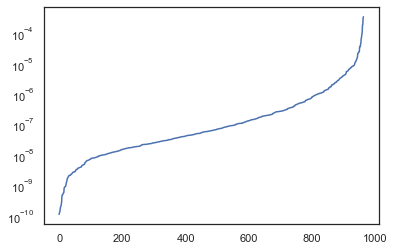

In [72]:
low_var = df_combined_doc.div(df_combined_doc.sum(axis=1), axis=0)
plt.plot(np.array(low_var.var().sort_values()))
plt.yscale('log')
low_var = low_var.var().sort_values()[:400]

In [73]:
df_combined_doc[low_var.index]

,looked,related,overall,doubt,low,surprised,keeping,saw,supposed,missing,...,loved,latest,minute,term,huge,decision,plan,tonight,beautiful,build
doc_ep_info_subreddit,,,,,,,,,,,,,,,,,,,,,
FlashTV,107.0,62.0,58.0,63.0,48.0,56.0,54.0,325.0,134.0,120.0,...,139.0,149.0,156.0,40.0,86.0,55.0,279.0,116.0,30.0,61.0
gameofthrones,64.0,41.0,35.0,42.0,33.0,32.0,33.0,204.0,87.0,70.0,...,114.0,56.0,72.0,64.0,99.0,82.0,152.0,72.0,60.0,30.0
westworld,45.0,28.0,23.0,28.0,22.0,22.0,25.0,142.0,58.0,51.0,...,46.0,33.0,34.0,47.0,44.0,42.0,138.0,21.0,42.0,52.0


In [74]:
# TfidfTransformer
# CountVectorizer
def tokenizer(doc):
    # TreebankWordTokenizer
    
    tokens = TreebankWordTokenizer().tokenize(doc)
#     tokens = pos_tag(tokens)
#     tokens = [ token[0] for token in tokens if ('NN' in token[1]) or ('JJ' in token[1]) or ('VB' in token[1])]
    return stop_and_stem( tokens )

vectorizer = CountVectorizer(tokenizer=tokenizer,
                                   preprocessor=None,
                                   min_df = .004,
                                   max_df = 0.7,
                                   ngram_range=(1,1),
                                   vocabulary = low_var.index
#                                  analyzer=stemmed_words
                                  )
doc_word = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(corpus),columns=vectorizer.get_feature_names())
df_combined_doc = pd.concat([doc_ep_info.add_prefix('doc_ep_info_')['doc_ep_info_mean_tomato'], doc_word], axis = 1).groupby("doc_ep_info_mean_tomato").sum()

In [75]:
df_combined_doc = df_combined_doc.T

In [76]:
df_combined_doc['diff'] = df_combined_doc[True]/df_combined_doc[True].sum() - df_combined_doc[False]/df_combined_doc[False].sum()
df_combined_doc.sort_values('diff').tail(20)

doc_ep_info_mean_tomato,False,True,diff
change,217.0,369.0,0.000815
knowledge,49.0,116.0,0.000831
introduced,39.0,102.0,0.000853
mentioned,114.0,216.0,0.000867
thanks,82.0,169.0,0.000893
course,86.0,176.0,0.000912
type,46.0,116.0,0.000921
premiere,41.0,110.0,0.000952
figure,72.0,158.0,0.000975
missing,76.0,165.0,0.000994


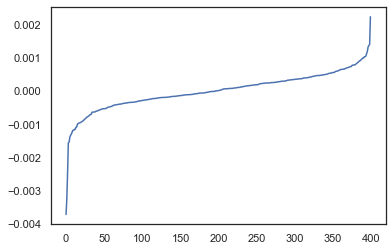

In [77]:
plt.plot(np.array(df_combined_doc['diff'].sort_values()))

(-0.5, 3999.5, 1999.5, -0.5)

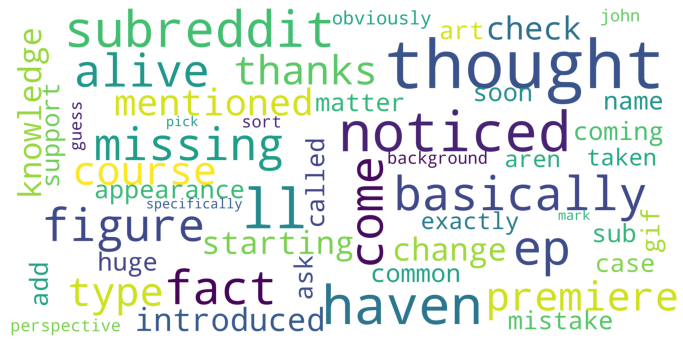

In [78]:
wordcloud = WordCloud(
        background_color='white',
        max_words=50,
        width=400,
        height=200,
        max_font_size=40, 
        scale=10,
        random_state=1
    ).generate_from_frequencies(df_combined_doc['diff'].sort_values())
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 3999.5, 1999.5, -0.5)

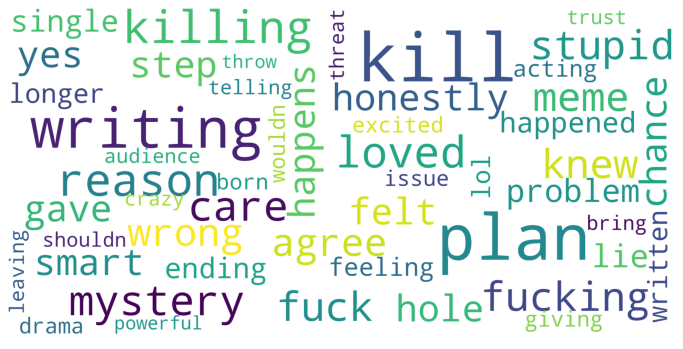

In [79]:
wordcloud = WordCloud(
        background_color='white',
        max_words=50,
        width=400,
        height=200,
        max_font_size=40, 
        scale=10,
        random_state=1
    ).generate_from_frequencies(-1 * df_combined_doc['diff'].sort_values())
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')